### Importing Needed packages


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

In [2]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Reading the data


In [4]:
df = pd.read_csv("HousePrice.csv")

# take a look at the dataset
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


### Types Columns

Columns whose variable type should be changed.


In [5]:
df.dtypes

Area           object
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price         float64
Price(USD)    float64
dtype: object

In [6]:
df['Area'] = pd.to_numeric(df['Area'], errors='coerce')

In [7]:
df[['Parking','Warehouse','Elevator']] = df[['Parking','Warehouse','Elevator']].astype(int)


### Data Exploration

Let's first have a descriptive exploration on our data.


In [8]:
# summarize the data
df.describe()

,Area,Room,Parking,Warehouse,Elevator,Price,Price(USD)
count,3473.000000,3479.000000,3479.000000,3479.000000,3479.000000,3.479000e+03,3.479000e+03
mean,106.774547,2.079908,0.847945,0.914631,0.787295,5.359023e+09,1.786341e+05
std,69.365567,0.758275,0.359126,0.279471,0.409279,8.099935e+09,2.699978e+05
min,30.000000,0.000000,0.000000,0.000000,0.000000,3.600000e+06,1.200000e+02
25%,69.000000,2.000000,1.000000,1.000000,1.000000,1.418250e+09,4.727500e+04
50%,90.000000,2.000000,1.000000,1.000000,1.000000,2.900000e+09,9.666667e+04
75%,120.000000,2.000000,1.000000,1.000000,1.000000,6.000000e+09,2.000000e+05
max,929.000000,5.000000,1.000000,1.000000,1.000000,9.240000e+10,3.080000e+06


In [9]:
df.shape

(3479, 8)

### Drop Line

Deleting the lines whose address column is empty or the size of the house is an unrealistic number.


In [10]:
df = df.dropna(subset = ['Address', 'Area'])
df.shape

(3450, 8)

### make columns


Let's create a column number for each unique address.

In [11]:
df['ACode'], unique_addresses = pd.factorize(df['Address'])

<h2>We find the effective columns in the output value</h2>

In [12]:
X = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode']]
y = df['Price(USD)']


In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
model = SGDRegressor(random_state=42)
model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode'],
    'Coefficient': model.coef_
})

print("Feature Importance Table (Linear):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Feature Importance Table (Linear):
     Feature    Coefficient
0       Area  167104.187907
1       Room   36071.167961
3  Warehouse   13707.228988
5      ACode   13447.650226
4   Elevator   11581.562375
2    Parking   -3367.695859


In [41]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

ModuleNotFoundError: No module named 'shap'

In [15]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})
print(feature_importance.sort_values(by='Importance', ascending=False))

     Feature  Importance
0       Area    0.720833
1       Room    0.040817
4   Elevator    0.004238
3  Warehouse    0.002008
5      ACode    0.001643
2    Parking   -0.000544


In [16]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})
print(feature_importance.sort_values(by='Importance', ascending=False))

     Feature  Importance
0       Area    0.742776
5      ACode    0.152947
1       Room    0.067644
4   Elevator    0.029933
2    Parking    0.004363
3  Warehouse    0.002337


Let's select some features to explore more.


In [17]:
cdf = df[['Area','Room','ACode','Price(USD)']].copy()
cdf.head(9)

,Area,Room,ACode,Price(USD)
0,63.0,1,0,61666.67
1,60.0,1,0,61666.67
2,79.0,2,1,18333.33
3,95.0,2,2,30083.33
4,123.0,2,3,233333.33
5,70.0,2,4,68333.33
6,87.0,2,1,20000.00
7,59.0,1,0,71666.67
8,54.0,2,5,16433.33


<h2 id="multiple_regression_model">Multiple Regression Model</h2>


In [18]:
X = cdf[['Area', 'Room', 'ACode']]
y = cdf['Price(USD)']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (X_train, Y_train)

print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)

Coefficients:  [ 2377.78494442 50611.7263509    242.9053321 ]
Intercept:  -192035.9010571488


<h2 id="prediction">Prediction</h2>


In [20]:
y_hat= regr.predict(X_test)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - Y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, Y_test))

Residual sum of squares: 39476629895.33
Variance score: 0.53


<h1>Polynomial</h1>

In [21]:
X = cdf[['Area', 'Room']].values
y = cdf['Price(USD)'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
poly = PolynomialFeatures(degree=4) 
X_poly = poly.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly, Y_train)

X_test_poly = poly.transform(X_test)
y_pred = model.predict(X_test_poly)

In [23]:
r2_score = model.score(X_test_poly, Y_test)
print(f'R² Score: {r2_score:.2f}')

R² Score: 0.74


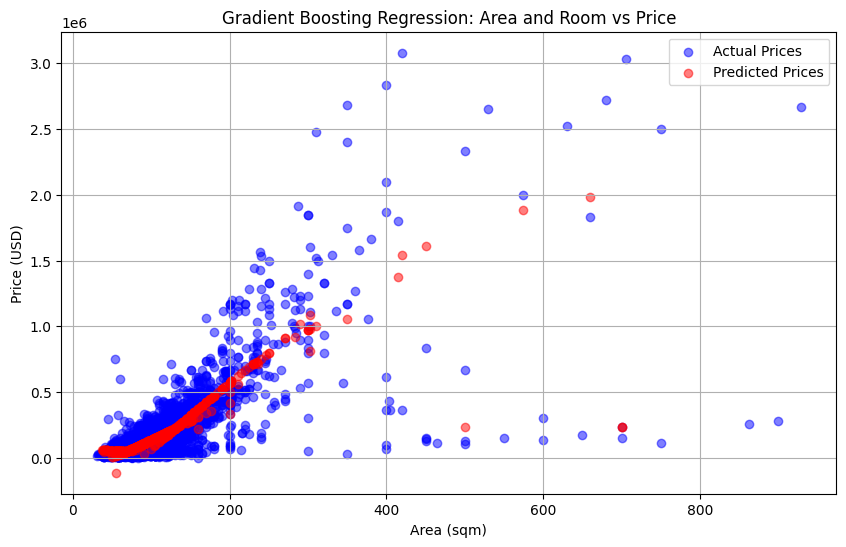

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(cdf['Area'], cdf['Price(USD)'], color='blue', label='Actual Prices', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, color='red', label='Predicted Prices', alpha=0.5)
plt.title('Gradient Boosting Regression: Area and Room vs Price')
plt.xlabel('Area (sqm)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

Help from kaggle

I felt that there might be a better way, so I asked for help from someone who had worked on a data frame similar to mine

https://www.kaggle.com/code/peimandaii/house-price-in-tehran

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import metrics
import warnings
import time
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [33]:
import xgboost as xgb
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import joblib

In [30]:
import folium

In [34]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD),ACode
0,63.0,1,1,1,1,Shahran,1.850000e+09,61666.67,0
1,60.0,1,1,1,1,Shahran,1.850000e+09,61666.67,0
2,79.0,2,1,1,1,Pardis,5.500000e+08,18333.33,1
3,95.0,2,1,1,1,Shahrake Qods,9.025000e+08,30083.33,2
4,123.0,2,1,1,1,Shahrake Gharb,7.000000e+09,233333.33,3
...,...,...,...,...,...,...,...,...,...
3474,86.0,2,1,1,1,Southern Janatabad,3.500000e+09,116666.67,16
3475,83.0,2,1,1,1,Niavaran,6.800000e+09,226666.67,78
3476,75.0,2,0,0,0,Parand,3.650000e+08,12166.67,27
3477,105.0,2,1,1,1,Dorous,5.600000e+09,186666.67,46


In [35]:
df.shape

(3450, 9)

In [37]:
df.isna().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price         0
Price(USD)    0
ACode         0
dtype: int64

An interesting way to number some columns

```python
def ab(name):
    a=[]
    for i in df[name]:
        if i==True:
            a.append(0)
        elif i==False:
            a.append(1)
    return a
df2['Elevator']=ab('Elevator')
df2['Warehouse']=ab('Warehouse')
df2['Parking']=ab('Parking')

```

In [44]:
print(pd.crosstab( df.Parking, df.Room), end='\n\n')
print(pd.crosstab( df.Warehouse, df.Room), end='\n\n')
print(pd.crosstab( df.Elevator, df.Room), end='\n\n')


Room     0    1     2    3   4   5
Parking                           
0        8  243   243   26   1   5
1        2  426  1695  704  69  28

Room       0    1     2    3   4   5
Warehouse                           
0          5  109   148   21   3   7
1          5  560  1790  709  67  26

Room      0    1     2    3   4   5
Elevator                           
0         8  282   350   49  17  27
1         2  387  1588  681  53   6



Method to convert string address for use in analysis
```python
address = df.Address.unique()
len_address = [i+1 for i in range(len(address))]
d = dict(zip(address,len_address))
df2['Number'] = df2['Address'].map(d)
```

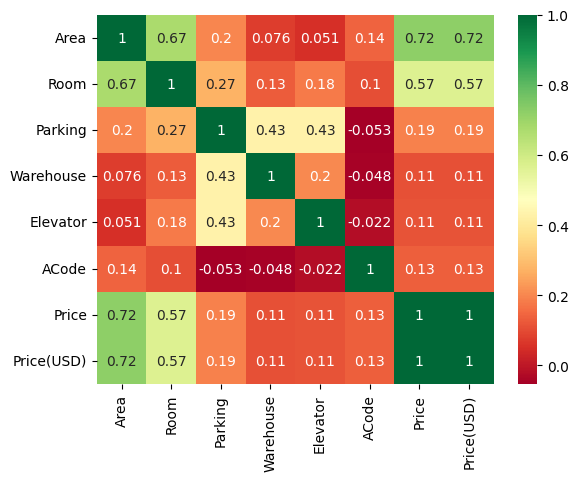

In [50]:
sns.heatmap(df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode', 'Price', 'Price(USD)']].corr(), annot=True,cmap='RdYlGn')
plt.show()

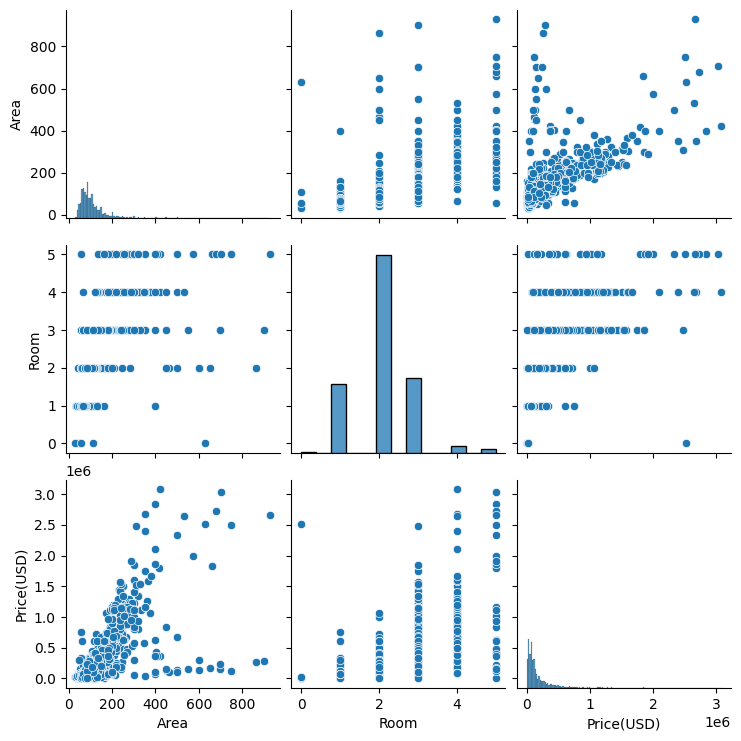

In [51]:
sns.pairplot(df[['Area','Room','Price(USD)']])
plt.show()

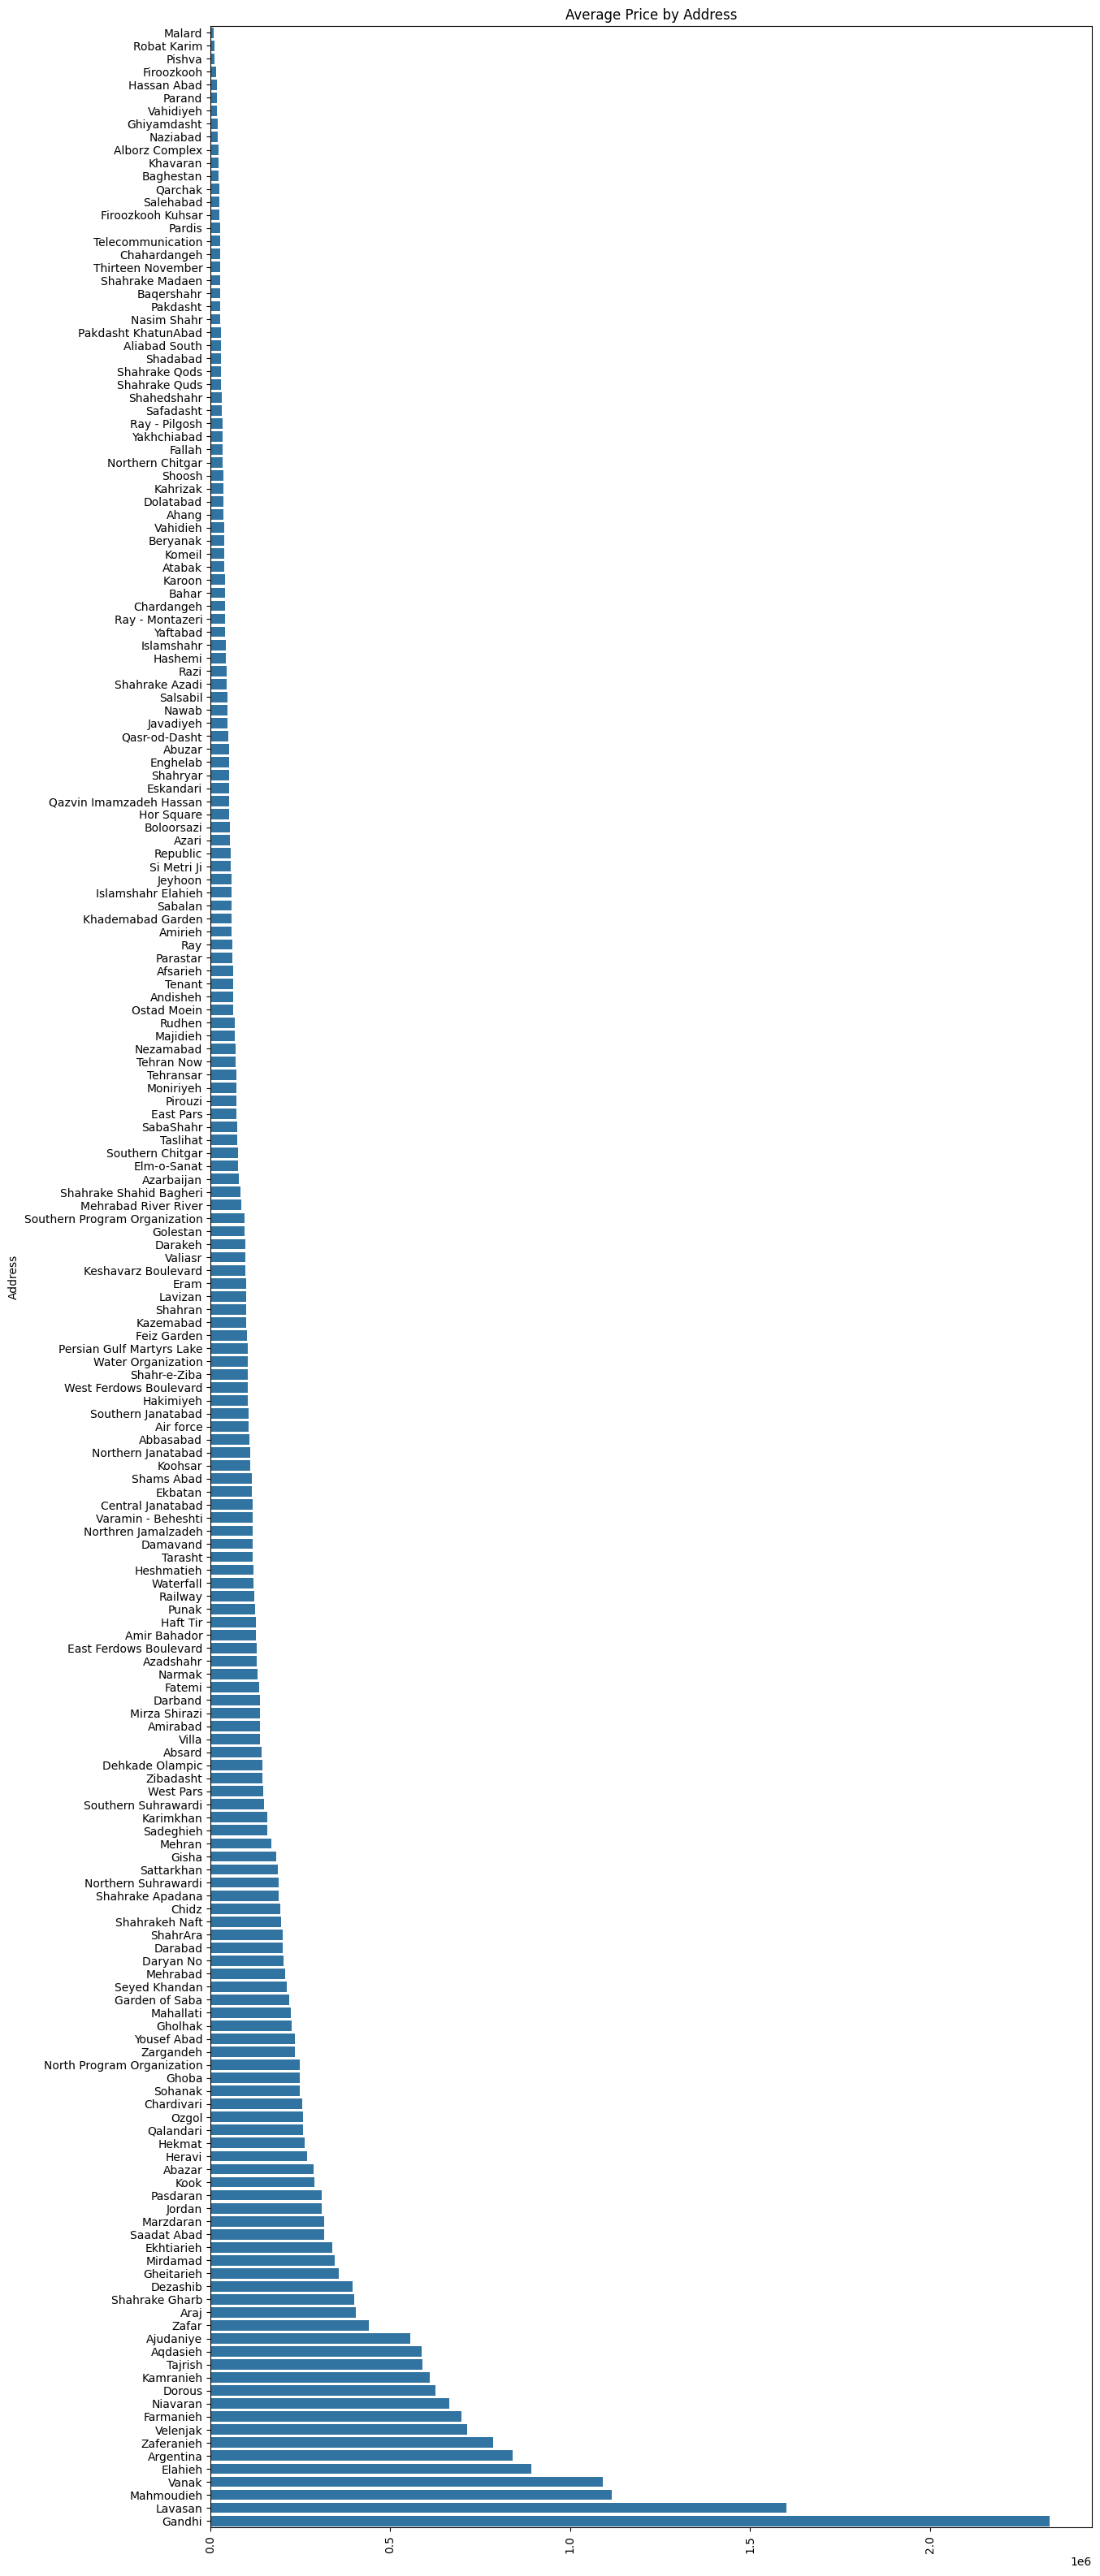

In [53]:
plt.figure(figsize=(14, 40))
mean_prices = df.groupby('Address')['Price(USD)'].mean().sort_values()
sns.barplot(x=mean_prices.values, y= mean_prices.index)
plt.xticks(rotation=90)
plt.title('Average Price by Address')
plt.show()

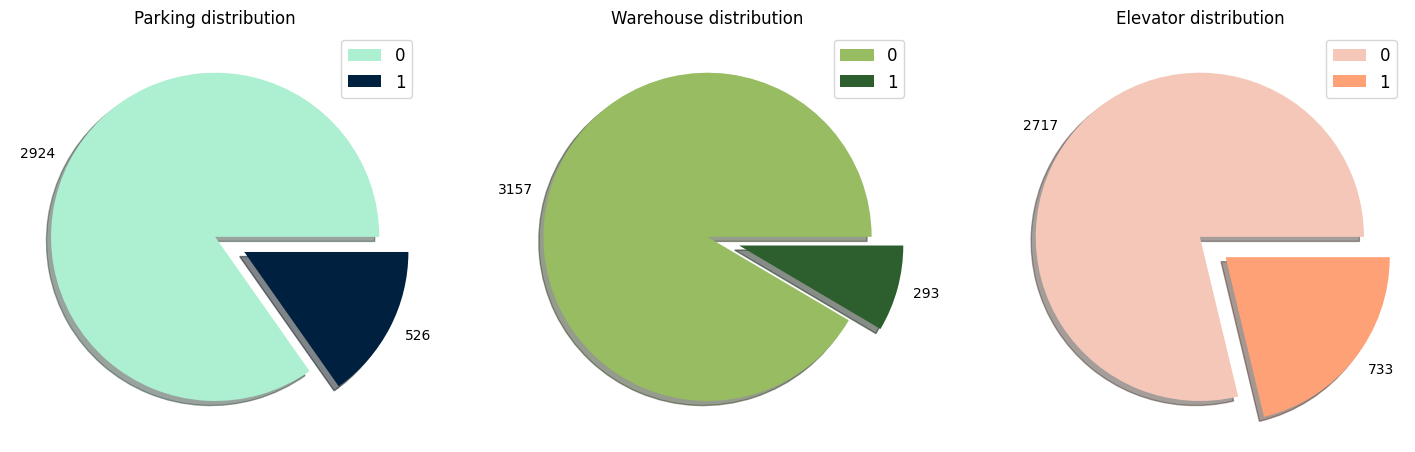

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=df.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

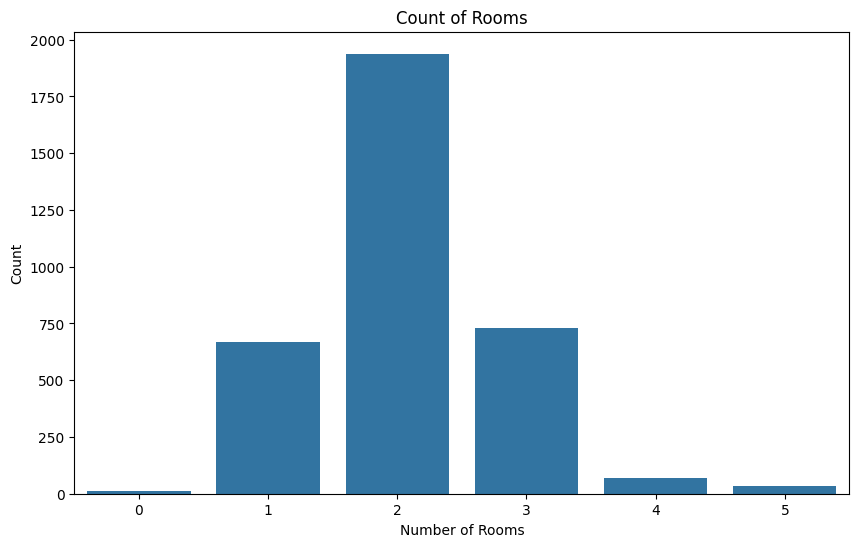

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Room'].value_counts().index, y=df['Room'].value_counts().values)
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.title('Count of Rooms')
plt.show()

Text(0, 0.5, 'Skewness Value')

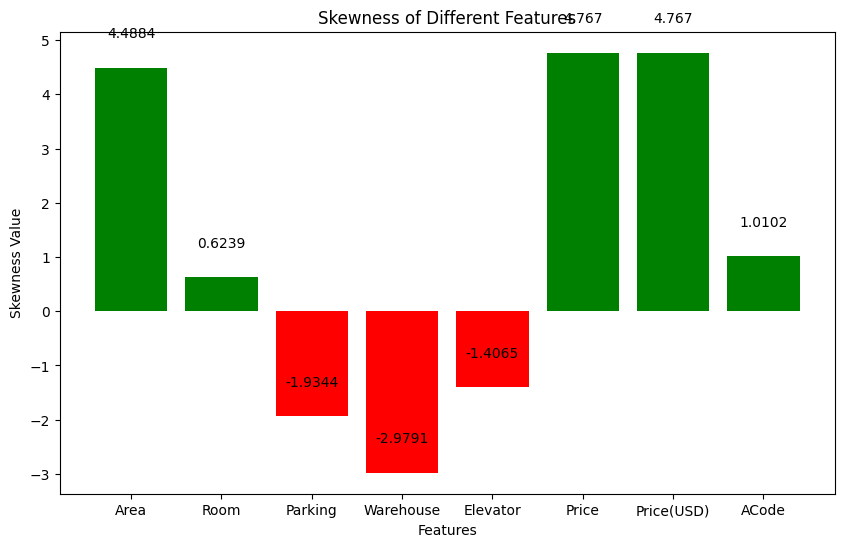

In [59]:
skews=df.drop('Address',axis='columns',inplace=False).skew()
colors = ['green' if value > 0 else 'red' for value in skews.values]

plt.figure(figsize=(10, 6))
plt.bar(skews.index, skews.values, color=colors)

for i in range(len(skews.values)):
        plt.text(skews.index[i], skews.values[i] + 0.5, str(round(skews.values[i], 4)), ha='center', va='bottom')
        
plt.title("Skewness of Different Features")
plt.xlabel("Features")
plt.ylabel("Skewness Value")


In [73]:
df3 = df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'ACode', 'Price', 'Price(USD)']].copy()
df3.shape

(3450, 8)

In [75]:
df3=df3[df3['Area']!=3600]

df3=df3[df3['Area']<122]

df3=df3[df3['Price(USD)']<=110000.000000]

df3['Area_per_Room'] = df3['Area'] / df3['Room']
df3['Amenities_per_Area'] = (df3['Parking'] + df3['Warehouse'] + df3['Elevator']) / df3['Area']
df3['Total_Amenities'] = df3['Parking'] + df3['Warehouse'] + df3['Elevator']
df3['Price_per_sqm'] = df3['Price'] / df3['Area']

df3 = df3[df3['Price_per_sqm'] <= 58888890]
df3.shape

(1845, 12)

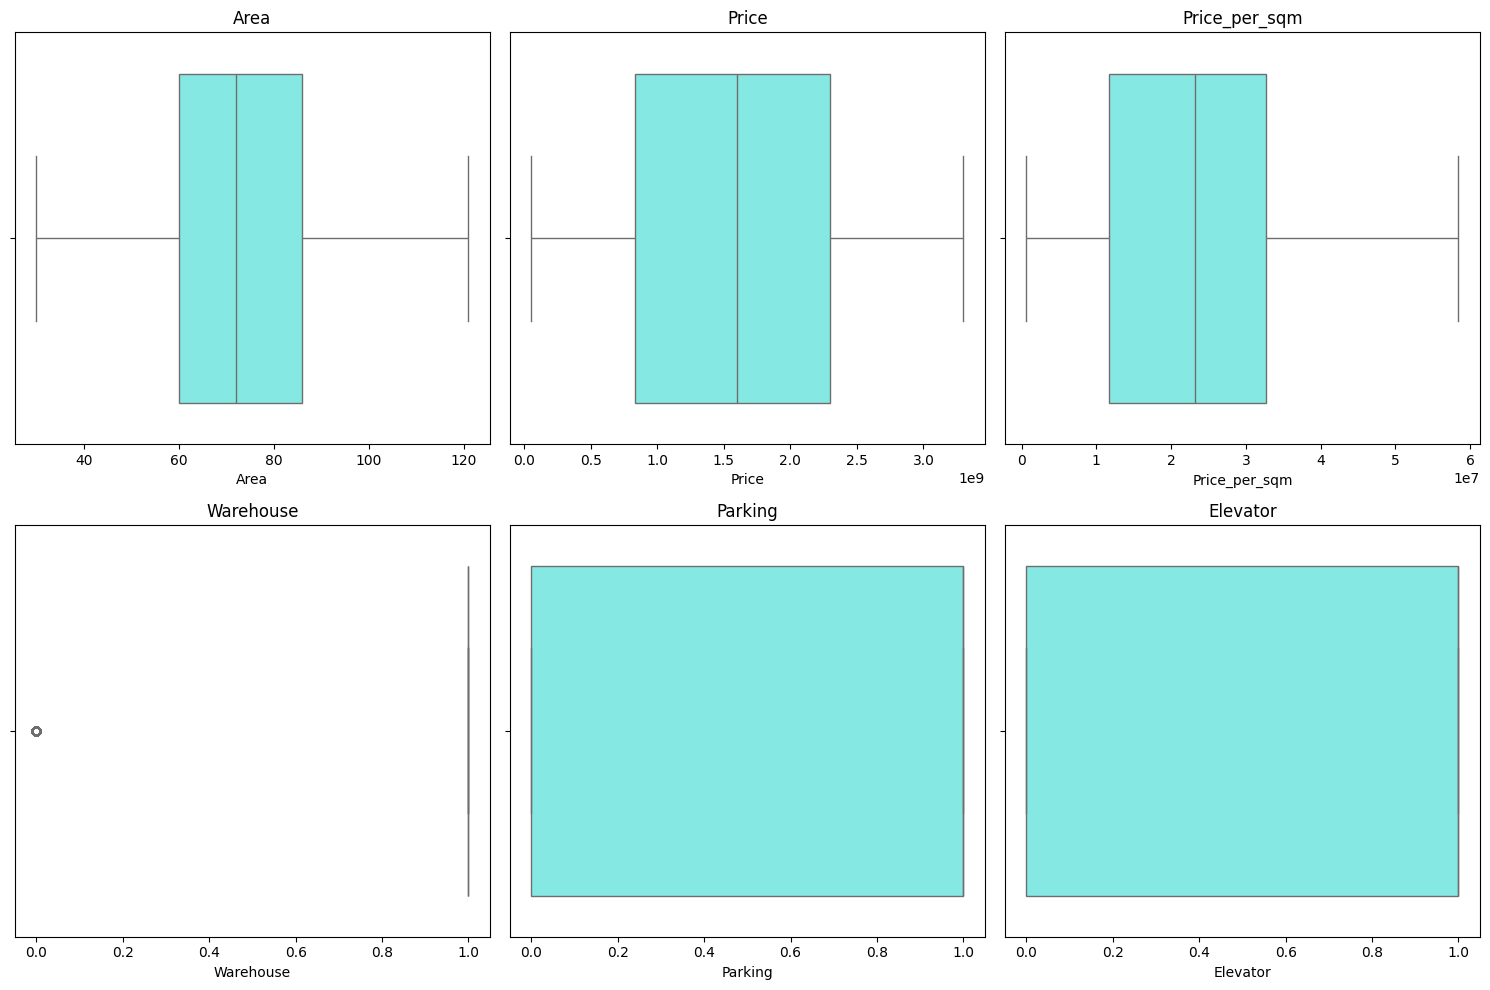

In [76]:
features = ['Area','Price','Price_per_sqm','Warehouse','Parking','Elevator']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, feature in enumerate(features):
    row, col = divmod(i, 3)  
    sns.boxplot(x=df3[feature], ax=axes[row, col], color="#75f8f2")
    axes[row, col].set_title(feature)

plt.tight_layout()
plt.show()

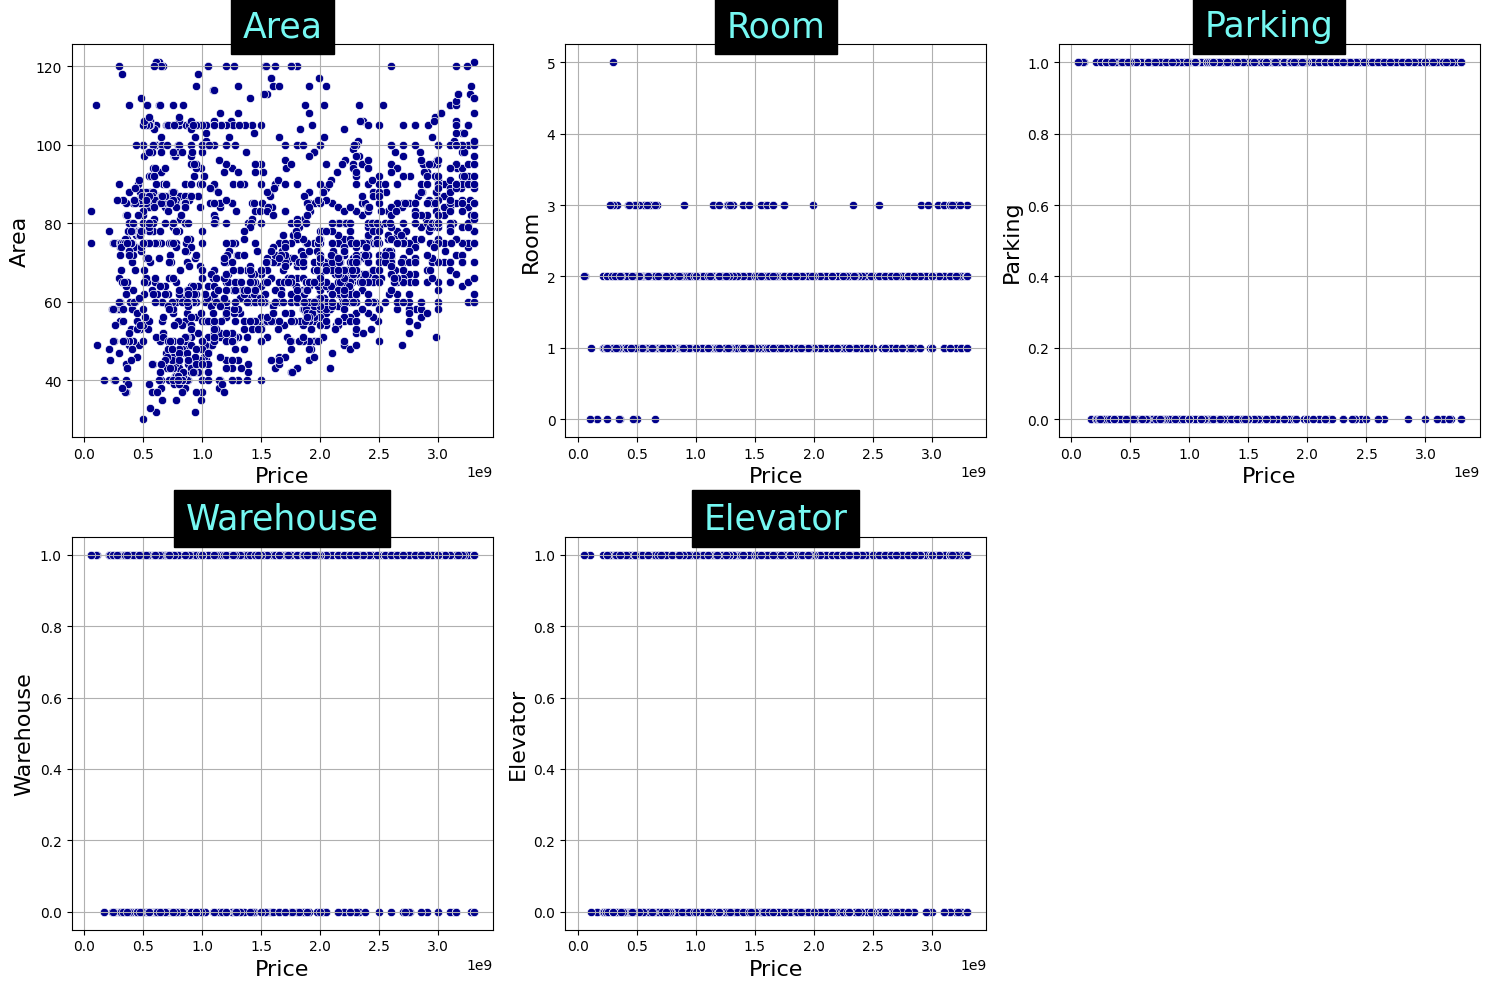

In [77]:
features = ['Area', 'Room', 'Parking', 'Warehouse', 'Elevator']
sns.set_palette("PiYG")
plt.figure(figsize=(15,10))
for idx, column in enumerate(features):
    plt.subplot(2, 3,  idx + 1)
    sns.scatterplot(x = df3['Price'], y=df3[column] , data = df3, color='darkblue')
    plt.title(column, backgroundcolor='black', color='#75f8f2', fontsize=25)
    plt.xlabel('Price', fontsize=16)
    plt.ylabel(column, fontsize=16)
    plt.grid()
plt.tight_layout()
plt.show()

In [78]:
max_threshold = df3['Price(USD)'].quantile(0.90)
min_threshold = df3['Price(USD)'].quantile(0.27)
df3 = df3[(df3['Price(USD)'] < max_threshold) & (df3['Price(USD)'] > min_threshold)]
df3.shape

(1160, 12)

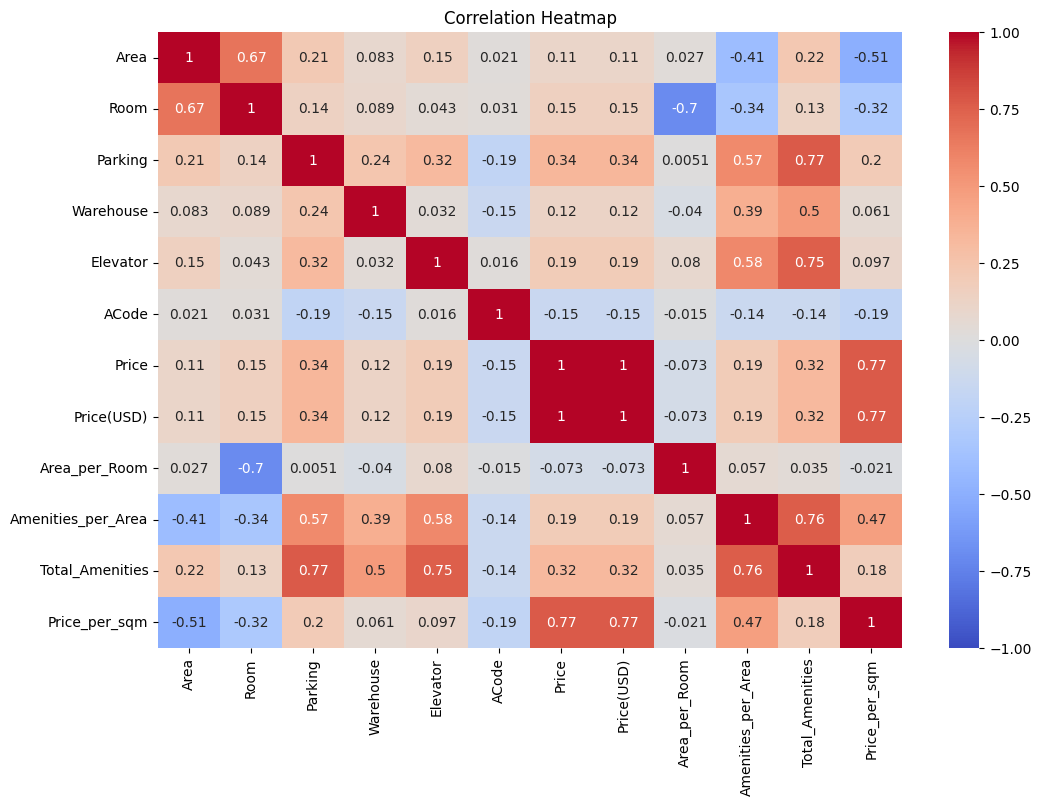

In [79]:
plt.figure(figsize=(12, 8))
correlation_matrix = df3.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [80]:
X = df3[['Area','Room','Price_per_sqm']]
y = df3['Price(USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (1044, 3)
shape of y train: (1044,)
shape of x test: (116, 3)
shape of y train: (116,)


In [81]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=24, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f' RMSE: {mse}, MAE: {mae}, R²: {r2}')

 RMSE: 7634141.394566117, MAE: 2099.2687365301726, R²: 0.9784145873131668


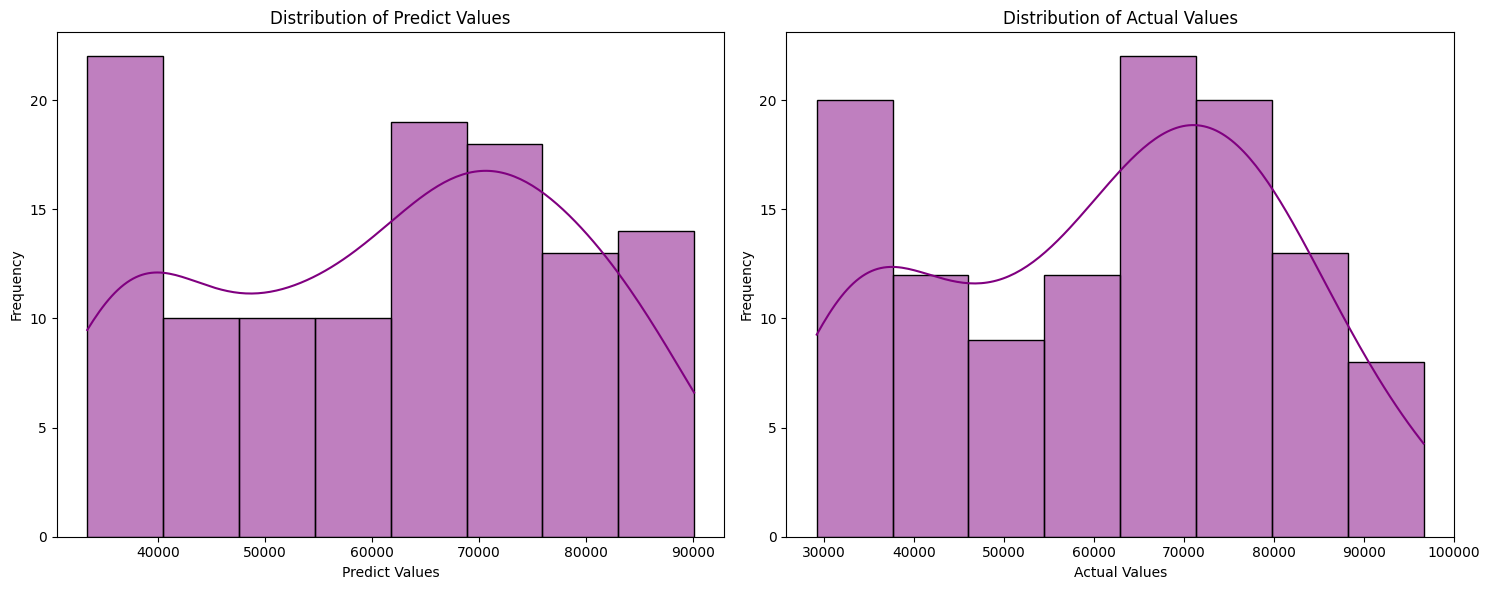

In [82]:
n1 = [y_pred,y_test]
n3=['Predict','Actual']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

for i in range(2):
    sns.histplot(n1[i], kde=True, color='purple', ax=axes[i])
    axes[i].set_xlabel(f'{n3[i]} Values')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {n3[i]} Values')

plt.tight_layout()
plt.show()